In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import numpy as np
import cmocean.cm as ocm
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import string
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import gsw

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
fig_dir  = os.path.join(proj_dir,'reports','devel','figures')
int_dir = os.path.join(data_dir,'interim')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from visualization.shiftedColorMap import shiftedColorMap
from roms_tools.cartesian_grid_2d import cartesian_grid_2d

tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)
from rotate_vector_roms import rotate_vector_roms
from log_progress import log_progress
from calc_z import calc_z

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Transects

In [2]:
woa_path = os.path.join(data_dir,'external','woa','woa18_A5B7_t15_04.nc')
woa_t = xr.open_dataset(woa_path,decode_times=False).mean('time')
woa_path = os.path.join(data_dir,'external','woa','woa18_A5B7_s15_04.nc')
woa_s = xr.open_dataset(woa_path,decode_times=False).mean('time')

t = woa_t.t_an
SP = woa_s.s_an

lon_2d,depth_2d = np.meshgrid(t.lon,t.depth)
lat_2d,depth_2d = np.meshgrid(t.lat,t.depth)
p = gsw.p_from_z(-depth_2d,lat_2d)
p_3d = np.repeat(p[:,:,np.newaxis],t.lon.size,axis=2)
lon_3d = np.repeat(lon_2d[:,np.newaxis,:],t.lat.size,axis=1)
lat_3d = np.repeat(lat_2d[:,:,np.newaxis],t.lon.size,axis=2)
SA = gsw.SA_from_SP(SP,p_3d,lon_3d,lat_3d)
pt = gsw.pt0_from_t(SA,t,p_3d)

woa_t['pt']=xr.DataArray(pt,dims=('depth','lat','lon'))

woa = xr.Dataset({'temp':woa_t.pt,'salt':woa_s.s_an})
woa['depth']=-woa.depth

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [3]:
temp_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_temp_DJFavg.nc')
salt_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_salt_DJFavg.nc')
#zeta_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_zeta_DJFavg.nc')
temp = xr.open_dataset(temp_path).temp.squeeze()
salt = xr.open_dataset(salt_path).salt.squeeze()
#zeta = xr.open_dataset(zeta_path).zeta.squeeze()
grd_path = os.path.join(data_dir,'interim','grd2_dV.nc')
grd = xr.open_dataset(grd_path)

In [4]:
def make_3D_depth(grd):

    h = grd.h.values
    zice = grd.zice.values
    theta_s = 7
    theta_b = 8
    hc = 250
    N = 31
    Vstretching = 4    
    zeta = np.zeros_like(grd.mask_rho)
        
    depths,s,C = calc_z(h,zice,theta_s,theta_b,hc,N,zeta,Vstretching)
        
    depth_3d =    xr.DataArray(depths,dims=['s_rho','eta_rho','xi_rho']) 
    #ds = ds.assign_coords(depth = xr.DataArray(depths,dims=['ocean_time','s_rho','eta_rho','xi_rho']))
    
    return depth_3d

import xesmf as xe
def regrid(da):
    da = da.assign_coords({'lat':grd.lat_rho,'lon':grd.lon_rho})
    #grd_out = xe.util.grid_2d(-180,180,1,-80.0,-64.5,1)
    regridder = xe.Regridder(da,woa_t,'nearest_s2d',reuse_weights=False)
    return regridder(da)

In [5]:
z_rho = make_3D_depth(grd)
waom = xr.Dataset({'temp':temp,'salt':salt,'depth':z_rho})#.set_coords('depth')
waom = regrid(waom)

Overwrite existing file: nearest_s2d_2650x3150_101x1440.nc 
 You can set reuse_weights=True to save computing time.


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ESMF/interface/cbindings.py:2095: DeprecationWarning: Call to deprecated function ESMP_FieldRegridStoreFile.
  def ESMP_FieldRegridStoreFile(srcField, dstField, filename,


using dimensions ('eta_rho', 'xi_rho') from data variable temp as the horizontal dimensions for this dataset.


In [6]:
waom = waom.set_coords('depth')

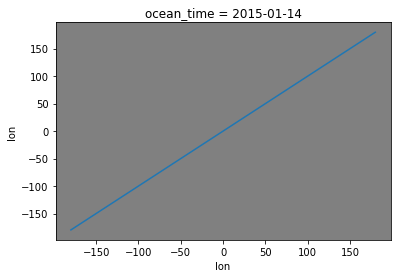

In [122]:
waom.temp.sel({'lat':slice(-78,-72.4)})

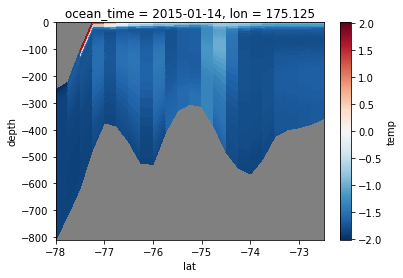

In [128]:
waom.temp.sel({'lat':slice(-78,-72.4)}).sel({'lon':175},method='nearest').plot(y='depth')

In [99]:
lon=175
lat=slice(-78,-72.4)

lon_m = lon
lon = slice(lon-0.25,lon+0.25)

woa_s,waom_s = comp_lon(lon,lat)
woa_s['depth']=woa_s.depth/1000
waom_s['depth']=waom_s.depth/1000

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


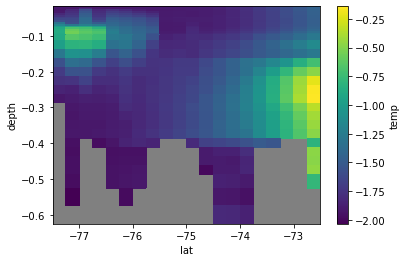

In [100]:
woa_s.temp.plot()

In [105]:
woa_s.notnull()

<xarray.Dataset>
Dimensions:  (depth: 35, lat: 20)
Coordinates:
  * depth    (depth) float64 -0.02 -0.025 -0.03 -0.035 ... -0.5 -0.55 -0.6
  * lat      (lat) float64 -77.38 -77.12 -76.88 -76.62 ... -73.12 -72.88 -72.62
Data variables:
    temp     (depth, lat) bool True True True True ... False False False False
    salt     (depth, lat) bool True True True True ... False False False False

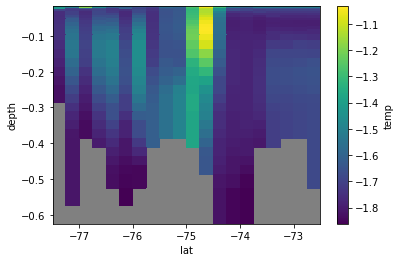

In [107]:
mask = (waom_s.depth==woa_s.depth) & (waom_s.lat==woa_s.lat)
waom_s.temp.where(mask).dropna('depth','all').dropna('lat','all').where(woa_s.temp.notnull()).plot()

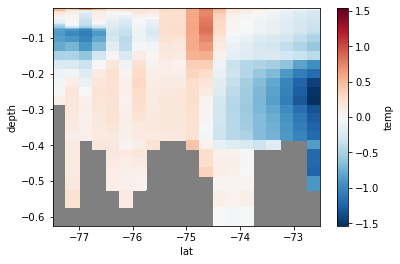

In [87]:
diff.plot()

In [7]:
def comp_lon(lon,lat):
    woa_s = woa.where(woa.depth<-15).sel({'lat':lat}).sel({'lon':lon},method='nearest')#.dropna('depth','all').dropna('lat','all')
    #pdb.set_trace()
    waom_sd = waom.sel({'lat':lat}).sel({'lon':lon},method='nearest')
    waom_s = interp_depth_1D(woa_s,waom_sd)#.dropna('depth','all').dropna('lat','all')
    
    mask = waom_sd.lat==woa_s.lat
    waom_sd = waom_sd.where(mask).dropna('lat','all')
    
    return woa_s.dropna('depth','all').dropna('lat','all'),waom_s.dropna('depth','all').dropna('lat','all'),waom_sd
woa_s,waom_s,waom_sd = comp_lon(70,slice(-68.25,-66.9))

NameError: name 'interp_depth_1D' is not defined

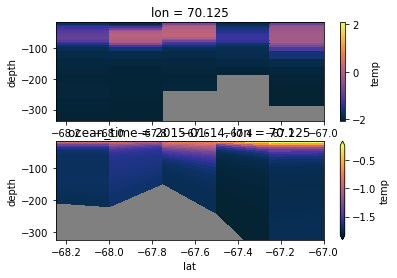

In [234]:
d= woa_s.depth.min()
fig,axes = plt.subplots(2)
ax1,ax2 = axes.flatten()
mask = (waom_sd.depth <= -15) & (waom_sd.depth>=woa_s.depth.min())
woa_s.temp.plot(ax=ax1,cmap=ocm.thermal)
waom_sd.temp.plot(ax=ax2,y='depth',cmap=ocm.thermal,vmax=waom_sd.temp.where(mask).max(),vmin=waom_sd.temp.where(mask).min())
ax2.set_ylim([d,-15])
ax2.set_xlim(ax1.get_xlim())


plt.show()

In [12]:
import pdb
plt.rcParams['axes.facecolor']='gray'

from scipy import interpolate

def interp_depth_1D(woa_section,waom_section):
    out = woa_section.copy(deep=True)
    for key in ['temp','salt']:
        for i in np.arange(out.lat.size):
            f = interpolate.interp1d(waom_section.depth[:,i],waom_section[key][:,i],
                                     fill_value='extrapolate',kind='nearest')
            out[key][:,i] = f(woa_section.depth)
            #pdb.set_trace()
            
    return out

def plot_inset(ax,lon,lat):
    
    lon=slice(lon-0.25,lon+0.25)

    ax.contourf(grd.mask_rho.values,colors=(('0.6','0.6','0.6')))
    (grd.h+grd.zice).where(grd.mask_rho).plot(ax=ax,cmap=ocm.deep,add_colorbar=False)
    ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'))
    ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black')) 
    ax.set_aspect('equal')
    ax.axis('off')

    mask = (grd.lon_rho>lon.start) & (grd.lon_rho<lon.stop) & (grd.lat_rho>lat.start) & (grd.lat_rho<lat.stop)
    #ax.contour(grd.mask_rho.where(mask), color='k', linestyle='-', linewidth=2)
    ax.contourf(grd.mask_rho.where(mask),colors='r')

    xlim = (grd.xi_rho.where(mask).min()-150,grd.xi_rho.where(mask).max()+150)
    ylim = (grd.eta_rho.where(mask).min()-150,grd.eta_rho.where(mask).max()+150)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    return ax

def comp_lon(lon,lat):
    woa_s = woa.where(woa.depth<-15).sel({'lat':lat}).sel({'lon':lon},method='nearest')#.dropna('depth','all').dropna('lat','all')
    #pdb.set_trace()
    waom_sd = waom.sel({'lat':lat}).sel({'lon':lon},method='nearest')
    waom_s = interp_depth_1D(woa_s,waom_sd)#.dropna('depth','all').dropna('lat','all')
    
    #mask = waom_sd.lat==woa_s.lat
    #waom_sd = waom_sd.where(mask).dropna('lat','all')
    
    return woa_s.dropna('depth','all').dropna('lat','all'),waom_s.dropna('depth','all').dropna('lat','all'),waom_sd

def make_rmse(diff_s):
    return (f' RMSE: {np.sqrt((diff_s**2).mean().values):.2f}\n'
            f' MAX:  {diff_s.max().values:.2f}\n'
            f' MIN:  {diff_s.min().values:.2f}')

def make_mean(diff_s):
    return (f' MEAN: {diff_s.mean().values:.2f}')

def plot_lon(lon,lat,name=False,sr=False,tr=False,loc=3):
    
    woa_s,waom_s,waom_sd = comp_lon(lon,lat)
    woa_s['depth']=woa_s.depth/1000
    waom_s['depth']=waom_s.depth/1000
    waom_sd['depth']=waom_sd.depth/1000
    #mask = (waom_sd.depth < woa_s.depth.max()) & (waom_sd.depth>woa_s.depth.min())
    diff = waom_s-woa_s
    
    #pdb.set_trace()
    if sr == False:
        sr = 2*diff.salt.std()#max(diff.salt.max(),-diff.salt.min())#0.3
    if tr == False:
        tr = 2*diff.temp.std()#max(diff.temp.max(),-diff.temp.min())#2
    
    
    fig,axes = plt.subplots(2,3,figsize = (8.27, 6.))
    
    ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()

    woa_s.temp.plot(ax=ax1,cmap=ocm.thermal,vmin=woa_s.temp.min(),vmax=woa_s.temp.max(),
            cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. [$^{\circ}$C]','pad':0.02})
    
    waom_sd.temp.plot(ax=ax2,y='depth',cmap=ocm.thermal,vmin=woa_s.temp.min(),vmax=woa_s.temp.max(),
                      #vmax=waom_sd.temp.where(mask).max(),
                      #vmin=waom_sd.temp.where(mask).min(),
            cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. [$^{\circ}$C]','pad':0.02})
    #ax2.set_ylim([woa_s.depth.min(),woa_s.depth.max()])
    #ax2.set_xlim([woa_s.lat.min(),woa_s.lat.max()])
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_xlim(ax1.get_xlim())
    #pdb.set_trace()

    diff.temp.plot(ax=ax3,vmin=-tr,vmax=tr,cmap='bwr',
            cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. diff. [$^{\circ}$C]','pad':0.02})

    woa_s.salt.plot(ax=ax4,cmap=ocm.haline,vmin=woa_s.salt.min(),vmax=woa_s.salt.max(),
            cbar_kwargs={'orientation': 'horizontal','label':'Salinity','pad':0.02})
    
    waom_sd.salt.plot(ax=ax5,y='depth',cmap=ocm.haline,  vmin=woa_s.salt.min(),vmax=woa_s.salt.max(),
            cbar_kwargs={'orientation': 'horizontal','label':'Salinity','pad':0.02}) 
    #ax5.set_ylim([woa_s.depth.min(),woa_s.depth.max()])
    #ax5.set_xlim([woa_s.lat.min(),woa_s.lat.max()])
    ax5.set_ylim(ax1.get_ylim())
    ax5.set_xlim(ax1.get_xlim())

    diff.salt.plot(ax=ax6,vmin=-sr,vmax=sr,cmap='bwr',
            cbar_kwargs={'orientation': 'horizontal','label':'Salinity diff.','pad':0.02})

    for ax in axes.flatten():
        ax.set_title('')
    
    for ax in [ax2,ax3,ax5,ax6]:
        ax.set_yticks([])
        ax.set_yticklabels('')
        ax.set_ylabel('')
        
    for ax in [ax4,ax5,ax6]:
        ax.set_xticks([])
        ax.set_xticklabels('')
        ax.set_xlabel('')
        
    for ax in [ax1,ax2,ax3]:
        ax.set_xlabel('Latitude [$^{\circ}$N]')
        
    for ax in [ax1,ax4]:
        ax.set_ylabel('Depth [km]')
    n=0
    for ax in axes.flatten():  
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.text(-0.1, -0.1, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
                size=12)
        n+=1    
    
    ax1.text(0.4,1.25, "WOA", transform=ax1.transAxes,size=12,weight='bold')
    ax2.text(0.4,1.25, "WAOM", transform=ax2.transAxes,size=12,weight='bold')
    ax3.text(0.3,1.25, "WAOM-WOA", transform=ax3.transAxes,size=12,weight='bold')
    
    
    
    ax3.text(0.01,0.01,make_mean(diff.temp),transform=ax3.transAxes,size=12)
    ax6.text(0.01,0.01,make_mean(diff.salt),transform=ax6.transAxes,size=12)
    
    from mpl_toolkits.axes_grid.inset_locator import inset_axes
    #axi = inset_axes(ax1,height="30%",width="30%", loc=loc)
    axi = ax1.inset_axes((0.0,0.0,.3,.3))
    axi = plot_inset(axi,lon,lat)
    
    ax1.text(0.31,0.01, f'Lon: {lon:.0f}E', transform=ax1.transAxes,size=12)
    
        
#fig.subplots_adjust(bottom=0.25)
#cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

#cbar = plt.colorbar(img, cax=cbar_ax,ticks=[0,50,200,500,1000,2000,4000], orientation="horizontal", pad=0.1)
#cbar.set_label(label='Depth in m',weight='bold')

    plt.subplots_adjust(wspace=0.15,hspace=0.15)

    if name:
        out_path = os.path.join(fig_dir,'Trans_WOA_WAOM_'+name+'.png')
        fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
    plt.show()
    
    #for key,diff_s in diff.items():
    #        print(f'{key}\n'
    #              f' RMSE: {(diff_s**2).mean().values:.2f}\n'
    #              f' MAX:  {diff_s.max().values:.2f}\n'
    #              f' MIN: {diff_s.min().values:.2f}\n')

<>:78: DeprecationWarning: invalid escape sequence \c
<>:83: DeprecationWarning: invalid escape sequence \c
<>:91: DeprecationWarning: invalid escape sequence \c
<>:120: DeprecationWarning: invalid escape sequence \c
<>:78: DeprecationWarning: invalid escape sequence \c
<>:83: DeprecationWarning: invalid escape sequence \c
<>:91: DeprecationWarning: invalid escape sequence \c
<>:120: DeprecationWarning: invalid escape sequence \c
<>:78: DeprecationWarning: invalid escape sequence \c
<>:83: DeprecationWarning: invalid escape sequence \c
<>:91: DeprecationWarning: invalid escape sequence \c
<>:120: DeprecationWarning: invalid escape sequence \c
<ipython-input-12-54b40a1f86f4>:78: DeprecationWarning: invalid escape sequence \c
  cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. [$^{\circ}$C]','pad':0.02})
<ipython-input-12-54b40a1f86f4>:83: DeprecationWarning: invalid escape sequence \c
  cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. [$^{\circ}$C]','pad':0.02})
<

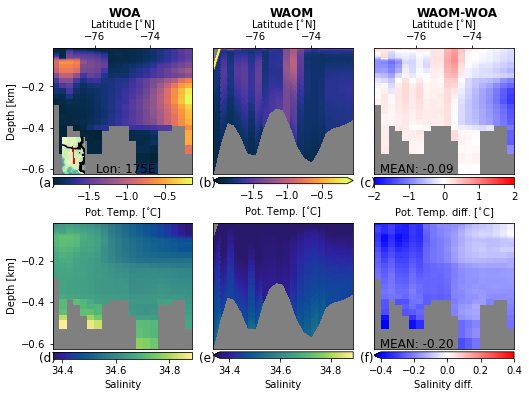

In [13]:
plot_lon(175,slice(-78,-72.4),'Ross_175E',0.4,2)
#plot_lon(175,slice(-78,-72.4),False,0.4,2)

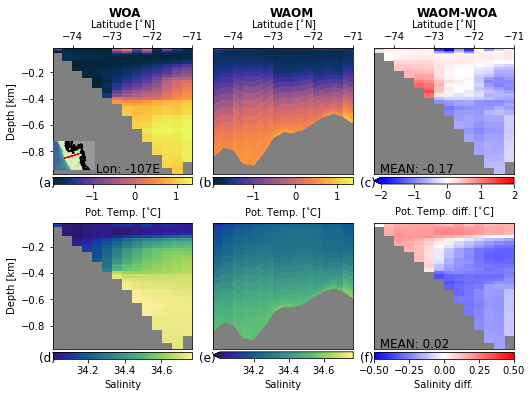

In [14]:
plot_lon(-107,slice(-75,-71),'Bell_107W',0.5,2)

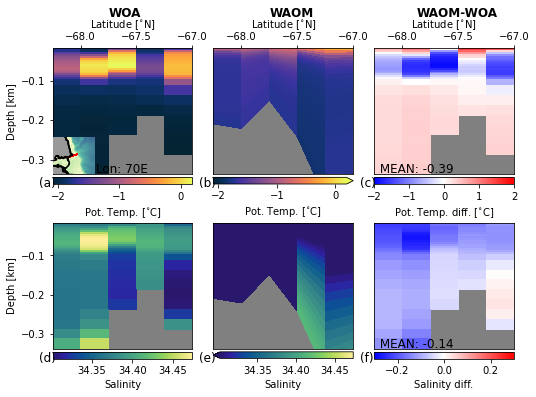

In [15]:
plot_lon(70,slice(-68.25,-66.9),'EA_70E',0.3,2)
#plot_lon(70,slice(-68.25,-66.9),False,0.3,2)

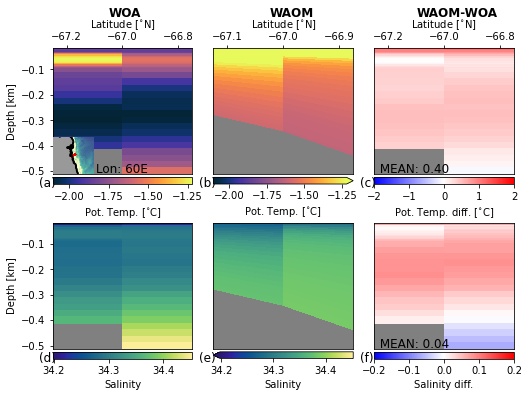

In [222]:
plot_lon(60,slice(-67.5,-66.7),'EA_60E',0.2,2)

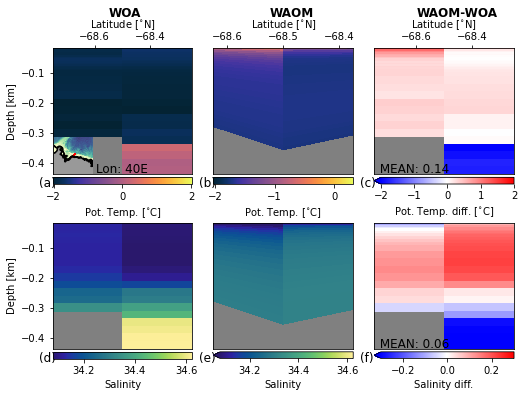

In [223]:
plot_lon(40,slice(-69,-68.2),'EA_40E',0.3,2)

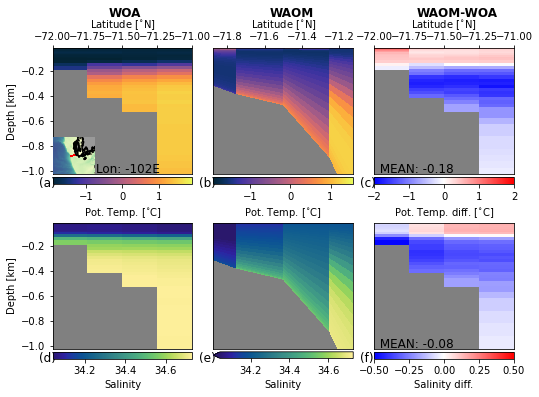

In [224]:
plot_lon(-102,slice(-72,-71),'Bell_102W',0.5,2)

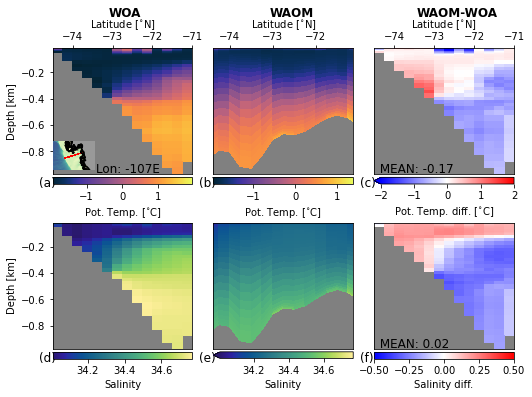

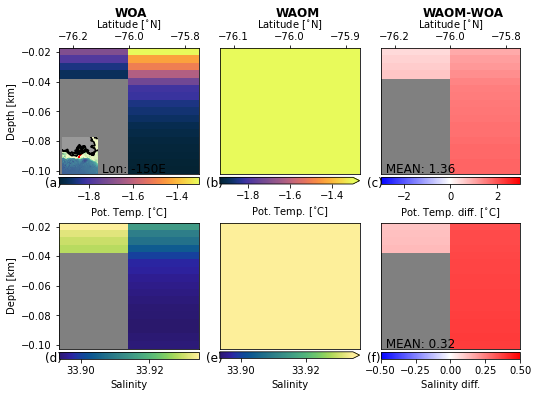

In [226]:
plot_lon(-150,slice(-76.5,-75.7),'Ross_150W',0.5,3)

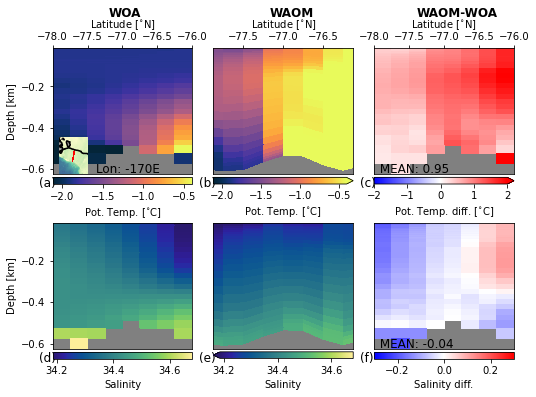

In [227]:
plot_lon(-170,slice(-78.5,-76),'Ross_170W',0.3,2)

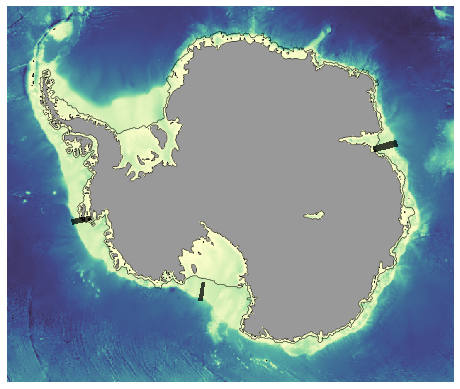

In [70]:
grd_path = os.path.join(data_dir,'interim','grd10_dV.nc')
grd10 = xr.open_dataset(grd_path)

#sels = [[118,120,-67,-65],
#       [-1,1,-70,-67],
#        [72,74,-69.5,-65],
#        [-84,-82,-73,-65]]

sels = [[-171,-169,-78,-75.5],
        #[-151,-149,-80,-65],
        [-103,-101,-73,-70.5],
        #[-1,1,-70,-67],
        #[39,41,-80,-65],
        #[59,61,-80,-65],
        [74,76,-69.5,-66.5]]
        #[139,141,-80,-65],
        #[174,176,-80,-65]]

plt.close()
fig,ax = plt.subplots(figsize=(8,8))
ax.contourf(grd10.mask_rho.values,colors=(('0.6','0.6','0.6')))
(grd10.h+grd10.zice).where(grd10.mask_rho).plot(cmap=ocm.deep,add_colorbar=False)#cbar_kwargs={'label':''})
ax.contour(-grd10.zice.where(grd10.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
ax.contour(grd10.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
ax.set_aspect('equal')
ax.axis('off')

for sel in sels:
    mask = (grd10.lon_rho>sel[0]) & (grd10.lon_rho<sel[1]) & (grd10.lat_rho>sel[2]) & (grd10.lat_rho<sel[3])
    ax.contourf(grd10.mask_rho.where(mask),alpha=0.75,colors='k')

out_path = os.path.join(fig_dir,'onshelf_trans_WOA_WAOM_map.png')
plt.savefig(out_path,format='png',dpi=375)
plt.show()

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


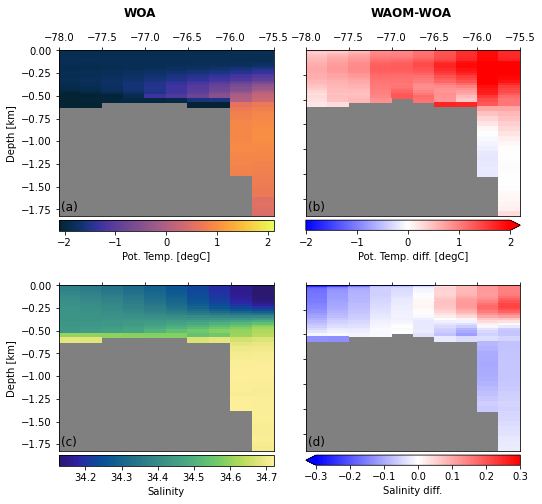

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


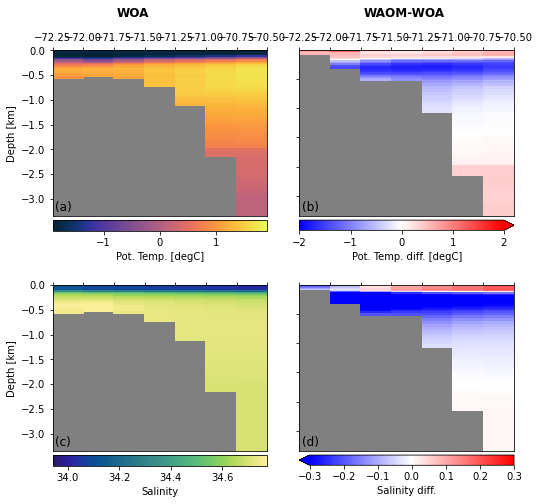

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


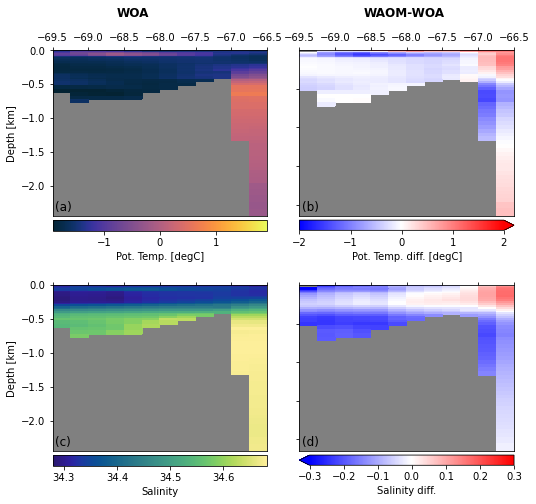

In [71]:
for sel in sels:
    plot_lon(slice(sel[0],sel[1]),slice(sel[2],sel[3]))